In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [2]:
# general settings for signal and noise
sample_freq = 1e6  # in Hz
length = 1.0  # in s
noise_power = 0.0  # in dB

# create a signal with varying power level (-100dB -> signal not present)
# 10 sections, each 0.1 seconds (1e5 samples) long
signal_power = np.repeat(
    [0.0, -100.0, 0.0, 0.0, 6.0, 5.0, -100.0, -10.0, -5.0, 0.0],
    sample_freq // 10)  # in dB

# create the signal (the 'soft speaker' kind)
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length, seed=None)
sig = wm.soft(f_center=1e4, power=signal_power, dB=True)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length, seed=None)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wm.num_samples == wgn.num_samples
num_samples = wm.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d ' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Signal power: 0.63 dB
Noise power:  0.00 dB
SNR:          0.63 dB
Num samples:  1000000 


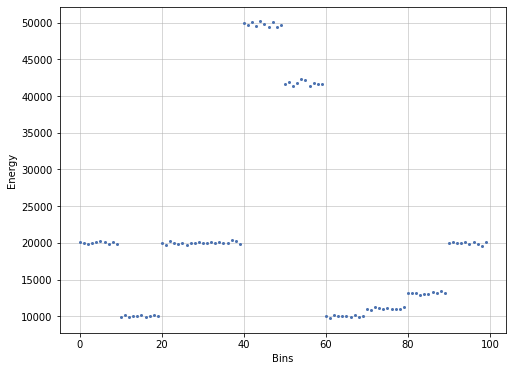

In [3]:
# split signal in 100 bins and apply energy detector on each bin
both_seg = np.split(both, 100)
eng = list(map(lambda x: ss.EnergyDetector.get(x), both_seg))

# plot the resulting bins (keep in mind that the energy here does not have any useful ('real') unit)
plt.figure(figsize=(8, 6))
plt.plot(eng, 'o', markersize=2, aa=True)
plt.xlabel(r'Bins')
plt.ylabel(r'Energy')
plt.grid(linewidth=0.5)
plt.show()

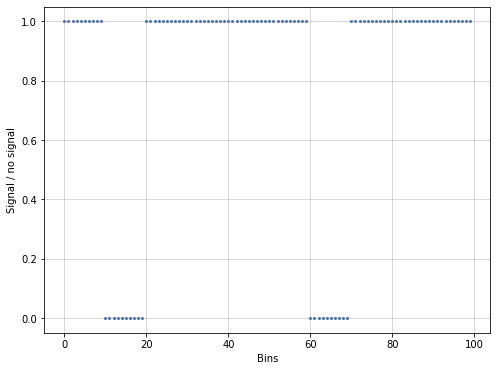

In [4]:
# calculate threshold (see notebook 3 for more info on that)
thr = ss.chi2_stats.thr(
    noise_power=noise_power,
    pfa=0.01,  # probability of false alarm 1%
    n=sample_freq // 100)  # number of samples per bin
result = eng > thr

# plot the result
plt.figure(figsize=(8, 6))
plt.plot(result, 'o', markersize=2, aa=True)
plt.xlabel(r'Bins')
plt.ylabel(r'Signal / no signal')
plt.grid(linewidth=0.5)
plt.show()

# As we can see the detection is near perfect. The energy detector is able to detect all occurrences of the signal.
# This is thanks to the fact the noise power is perfectly known.
# However, as we will see later this is not always the case. Therefore, detection performance will also degrade...